In [1]:
import pandas as pd
import torch
import numpy as np
import re

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import silhouette_score

c:\Users\nguye\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned.csv', low_memory=False)

In [9]:
data = df[['pt', 'SOC']].copy()
data = data.drop_duplicates(subset=['pt'])

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['pt_clean'] = data['pt'].apply(clean_text)

In [11]:
# model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast
# embeddings = model.encode(data['pt_clean'].tolist(), show_progress_bar=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [13]:
def get_cls_embedding(texts, tokenizer, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=64)
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)

In [14]:
texts = data['pt_clean'].tolist()
embeddings = get_cls_embedding(texts, tokenizer, model)

100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


In [9]:
# pca = PCA(n_components=50, random_state=42)
# X_reduced = pca.fit_transform(embeddings)

In [15]:
X_reduced = embeddings

In [16]:
kmeans = KMeans(n_clusters=27, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(X_reduced)

In [17]:
gmm = GaussianMixture(n_components=27, covariance_type='full' , random_state=42)
data['cluster_gmm'] = gmm.fit_predict(X_reduced)

In [18]:
def assign_cluster_soc(data, cluster_col):
    known = data[data['SOC'].notnull()]
    cluster_to_soc = known.groupby(cluster_col)['SOC'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    return data[cluster_col].map(cluster_to_soc)

In [19]:
for method in ['kmeans', 'gmm']:
    col = f'cluster_{method}'
    data[f'SOC_imputed_{method}'] = data['SOC']
    mask_missing = data['SOC'].isnull()
    data.loc[mask_missing, f'SOC_imputed_{method}'] = assign_cluster_soc(data, col)[mask_missing]

In [20]:
for method in ['kmeans', 'gmm']:
    filled = data['SOC_imputed_' + method].notnull().sum()
    print(f'{method.upper()} imputed SOCs: {filled} / {len(data)}')

KMEANS imputed SOCs: 8963 / 8963
GMM imputed SOCs: 8963 / 8963


In [21]:
sil_score_kmeans = silhouette_score(embeddings, data['cluster_kmeans'])
sil_score_gmm = silhouette_score(embeddings, data['cluster_gmm'])
print(f"KMeans Silhouette Score: {sil_score_kmeans}")
print(f"GMM Silhouette Score: {sil_score_gmm}")

KMeans Silhouette Score: 0.04875442758202553
GMM Silhouette Score: 0.04875442758202553


In [22]:
data[data['SOC'].isnull()]['SOC_imputed_kmeans'].value_counts()

SOC_imputed_kmeans
Gastrointestinal disorders                                             353
Infections and infestations                                            264
Nervous system disorders                                               146
Musculoskeletal and connective tissue disorders                        141
Psychiatric disorders                                                  108
Metabolism and nutrition disorders                                     101
Skin and subcutaneous tissue disorders                                  77
General disorders and administration site conditions                    67
Investigations                                                          60
Vascular disorders                                                      50
Surgical and medical procedures                                         48
Pregnancy, puerperium and perinatal conditions                          48
Eye disorders                                                           43
Cardia

In [23]:
data[data['SOC'].isnull()]['SOC_imputed_gmm'].value_counts()

SOC_imputed_gmm
Gastrointestinal disorders                                             353
Infections and infestations                                            264
Nervous system disorders                                               146
Musculoskeletal and connective tissue disorders                        141
Psychiatric disorders                                                  108
Metabolism and nutrition disorders                                     101
Skin and subcutaneous tissue disorders                                  77
General disorders and administration site conditions                    67
Investigations                                                          60
Vascular disorders                                                      50
Surgical and medical procedures                                         48
Pregnancy, puerperium and perinatal conditions                          48
Eye disorders                                                           43
Cardiac d

In [39]:
cluster_kmeans_to_label = (
    data.groupby('cluster_kmeans')['SOC']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

In [ ]:
data_filled = data[data['SOC'].notnull()].copy()
data_filled['SOC_imputed_kmeans'] = data_filled['cluster_kmeans'].map(cluster_kmeans_to_label)
data_filled['kmeans_check'] = (data_filled['SOC'] == data_filled['SOC_imputed_kmeans']).astype(int)

In [46]:
sum(data_filled['kmeans_check']) / len(data_filled)

0.5148729042725798

In [44]:
data_filled['SOC'].value_counts().head(5)

SOC
Investigations                                                         939
Neoplasms benign, malignant and unspecified (incl cysts and polyps)    702
Infections and infestations                                            660
Surgical and medical procedures                                        543
Gastrointestinal disorders                                             536
Name: count, dtype: int64

In [20]:
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- Reduce to 2D using UMAP
# umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
# X_umap = umap_model.fit_transform(X_reduced)

# data['umap_x'] = X_umap[:, 0]
# data['umap_y'] = X_umap[:, 1]

# # --- Plotting function
# def plot_clusters(data, hue, title):
#     plt.figure(figsize=(12, 8))
#     sns.scatterplot(
#         x='umap_x', y='umap_y',
#         hue=hue,
#         data=data,
#         palette='tab20',
#         s=30,
#         alpha=0.8,
#         edgecolor='k'
#     )
#     plt.title(title)
#     # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.tight_layout()
#     plt.show()

# # --- 1. Plot original SOC labels
# plot_clusters(data[data['SOC'].notnull()], hue='SOC', title='UMAP Projection by Original SOC Labels')

# # --- 2. Plot KMeans clusters
# plot_clusters(data, hue='cluster_kmeans', title='UMAP Projection by KMeans Clusters')

# # --- 3. Plot GMM clusters
# plot_clusters(data, hue='cluster_gmm', title='UMAP Projection by GMM Clusters')

100%|██████████| 232/232 [01:21<00:00,  2.83it/s]
c:\Users\nguye\anaconda3\envs\NLP\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nguye\anaconda3\envs\NLP\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\nguye\AppData\Local\Temp\ipykernel_11820\1225133520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filled['umap_x'] = X_umap[:, 0]
C:\Users\nguye\AppData\Local\Temp\ipykernel_11820\1225133520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

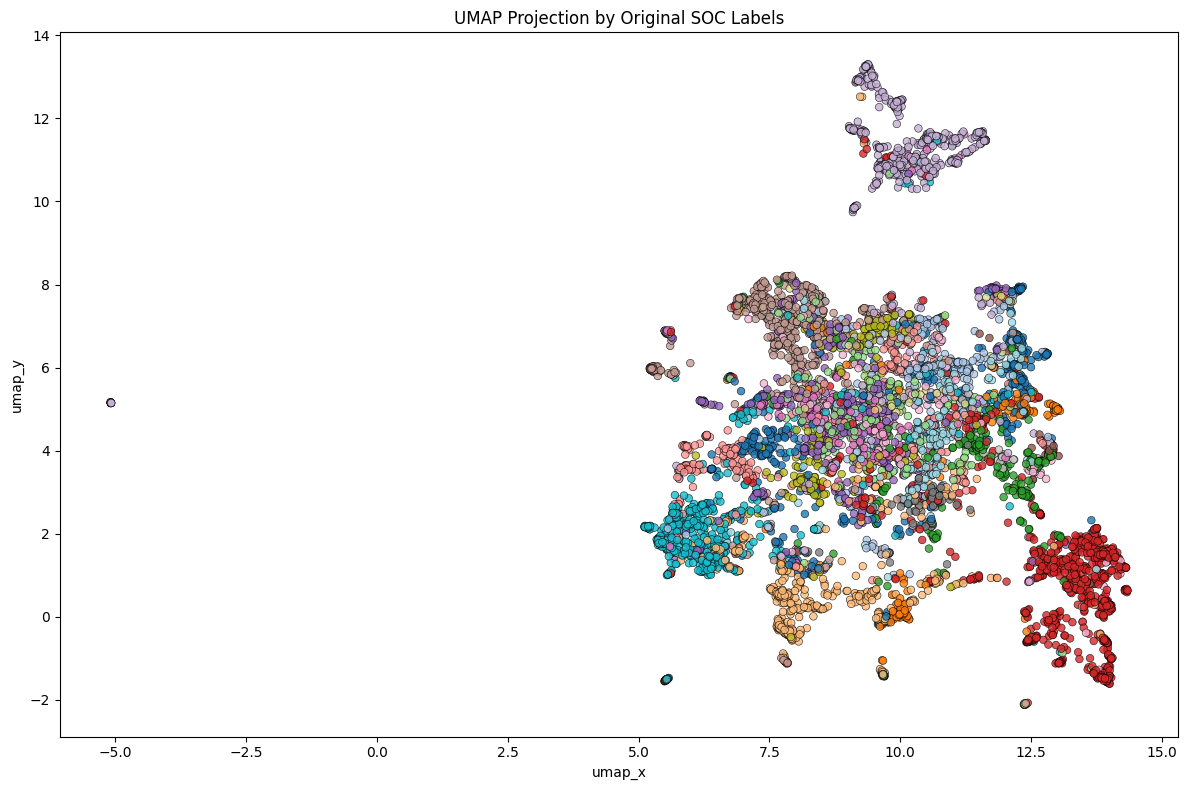

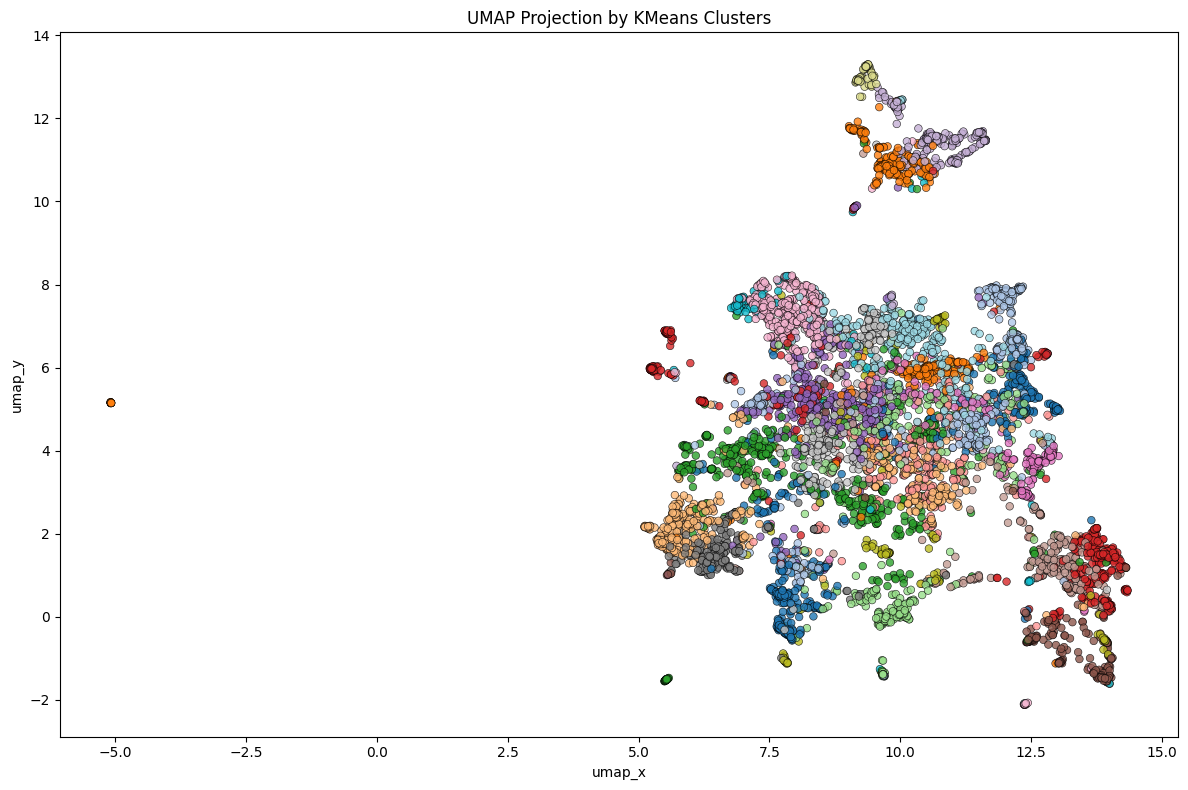

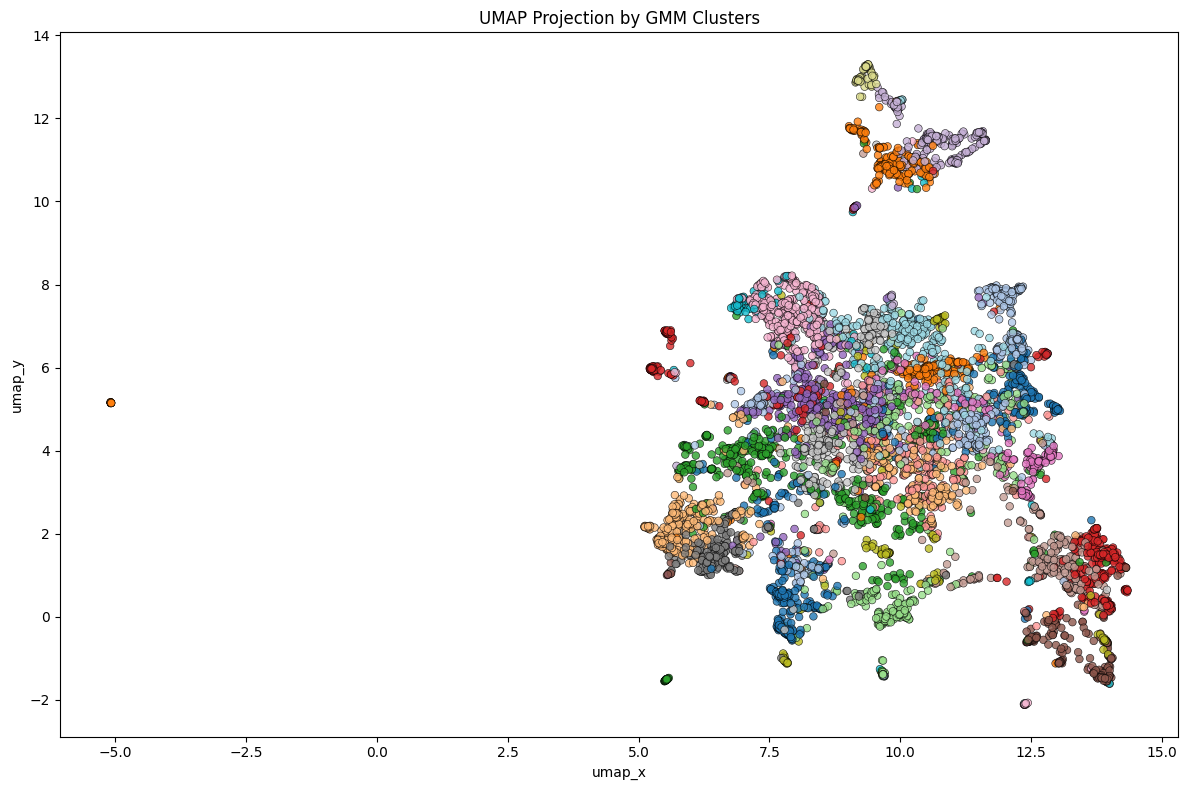

In [29]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reduce to 2D using UMAP
umap_model = umap.UMAP(n_neighbors=27, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(get_cls_embedding(data_filled['pt_clean'].tolist(), tokenizer, model))

data_filled['umap_x'] = X_umap[:, 0]
data_filled['umap_y'] = X_umap[:, 1]

# --- Plotting function
def plot_clusters(data, hue, title):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='umap_x', y='umap_y',
        hue=hue,
        data=data,
        palette='tab20',
        s=30,
        alpha=0.8,
        edgecolor='k',
        legend=False  # Disable legend for clarity
    )
    plt.title(title)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# --- 1. Plot original SOC labels
plot_clusters(data_filled[data_filled['SOC'].notnull()], hue='SOC', title='UMAP Projection by Original SOC Labels')

# --- 2. Plot KMeans clusters
plot_clusters(data_filled[data_filled['SOC'].notnull()], hue='cluster_kmeans', title='UMAP Projection by KMeans Clusters')

# --- 3. Plot GMM clusters
plot_clusters(data_filled[data_filled['SOC'].notnull()], hue='cluster_gmm', title='UMAP Projection by GMM Clusters')

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reduce to 2D using UMAP
umap_model = umap.UMAP(n_neighbors=27, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_reduced)

data['umap_x'] = X_umap[:, 0]
data['umap_y'] = X_umap[:, 1]

# --- Plotting function
def plot_clusters(data, hue, title):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='umap_x', y='umap_y',
        hue=hue,
        data=data,
        palette='tab20',
        s=30,
        alpha=0.8,
        edgecolor='k',
        legend=False  # Disable legend for clarity
    )
    plt.title(title)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# --- 1. Plot original SOC labels
plot_clusters(data[data['SOC'].notnull()], hue='SOC', title='UMAP Projection by Original SOC Labels')

# --- 2. Plot KMeans clusters
plot_clusters(data[data['SOC'].notnull()], hue='cluster_kmeans', title='UMAP Projection by KMeans Clusters')

# --- 3. Plot GMM clusters
plot_clusters(data[data['SOC'].notnull()], hue='cluster_gmm', title='UMAP Projection by GMM Clusters')